# SENDY LOGISTICS DATA PREPROCESING 
---
1. Make your **1st line a comment**, just to give clarity to the Team about the task/code used.
2. If you happen to get a **CODE snippet** from **stackoverflow/Blog**, Make your **2nd line the link referencing the code/post**. for later reference if team members need clarity.

---
## HEADS UP
*The following steps will serve as a guide-line not mandatory step and they might not be in order.*

- split data into subsets (train & validation/test)
- data preparation
    - imputing misssing values
    - Changing Data Types (if necessary e.g [df.convert_dtypes()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.convert_dtypes.html)| [df.astype()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html) based features [pd.to_datetime(df['date'])](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html?highlight=to_datetime))
    - One Hot Encoding [more](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
    - Ordinal Encoding [more](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder)
    - Target Encording (Do more Research)
    - Target Transformation Regressor (Do [more Research](https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html?highlight=transform#sklearn.compose.TransformedTargetRegressor) )
        - Target might be transformed when linear algorithms such as Linear Regression, etc.
- [Scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=scale#sklearn.preprocessing.StandardScaler) & transform 
- feature Engineering (read more)
    - Feature Interaction
    - Bin Numeric Features
    - Trigonometry Features
    - Group Features
    - Polynomial Features
    - Combine Rare Levels
- feature Selection (AKA variables selection)
    - SelectKBest, SelectFromModel, RFE [more here](https://scikit-learn.org/stable/search.html?q=feature+selection) 
    - Feature Importance
    - collinearity (Remove Multicollinearity using threshold >= 0.9, )
        - rules: if feature A is highly correlated with feature B but A is less corelated with Target, then Remove Feature A
    - Principal Component Analysis (PCA)
    - VarianceThreshold [view](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html?highlight=feature%20selection#sklearn.feature_selection.VarianceThreshold)
        - SET Threshold and Ignore Low Variance fearues below the Threshold.
- Clustering (Removing Outliers / creating clusters)
---

# 1. Library Imports
---
Keep it clean, import Libraries at the Top!

In [0]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from datetime import datetime


# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# More imports Below
from sklearn.ensemble import RandomForestRegressor

# evaluate
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV


# 2. Import Datasets
---
- By Default the notebook is using the github links to fetch data remotely, change to local if need be. 
> e.g replace URL_TRAIN with URL_local_TRAIN
- DO NOT FORGET TO CHANGE BACK THE LINKS BEFORE CREATING A PULL REQUEST
> Use The following Links for Local Machine NoteBooks/Jupyterlab (this will save data)
>This assumes the notebook.ipynb is inside the Notebooks folder

```python

    URL_local_TRAIN = "/data/Train.csv"
    URL_local_TEST = "/data/Test.csv"
    URL_local_RIDERS = "/data/Riders.csv" 
    URL_local_DD = "/data/VariableDefinitions.csv"

```

In [0]:
# CONSTANTS

URL_TRAIN = "https://raw.githubusercontent.com/Explore-EDSA-2020/Data-public/master/Train.csv"
URL_TEST = "https://raw.githubusercontent.com/Explore-EDSA-2020/Data-public/master/Test.csv"
URL_RIDERS = "https://raw.githubusercontent.com/Explore-EDSA-2020/Data-public/master/Riders.csv" 
URL_DD = "https://raw.githubusercontent.com/Explore-EDSA-2020/Data-public/master/VariableDefinitions.csv" # Data Dictionary
url_submission="https://raw.githubusercontent.com/Explore-EDSA-2020/Data-public/master/SampleSubmission.csv"


In [0]:
# reading the data to dataframe

train_df  = pd.read_csv(URL_TRAIN)
test_df   = pd.read_csv(URL_TEST)
riders_df = pd.read_csv(URL_RIDERS)
data_dictionary_df = pd.read_csv(URL_DD)


In [18]:
# making a copy of the data to avoid altering the original data
train_riders = train_df.copy()
test_riders  = test_df.copy()

# merged train with riders
train_riders = train_riders.merge(riders_df, how='left', on='Rider Id')
test_riders  = test_riders.merge(riders_df, how='left', on='Rider Id')

# view dimension
print('train without riders: ', train_df.shape)
print('train merged with riders: ', train_riders.shape)
print('---------------------------------------')
print('test without riders: ', test_df.shape)
print('test merged with riders: ', test_riders.shape)

train without riders:  (21201, 29)
train merged with riders:  (21201, 33)
---------------------------------------
test without riders:  (7068, 25)
test merged with riders:  (7068, 29)


In [0]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    plt.tight_layout()
    plt.show()

In [0]:
def get_missing_values(df, threshold =0):
    """Returns the feature name and the % of  missing values as dataframe"""

    return pd.DataFrame(data= {column: (df[column].isnull().mean()) for column in df.columns if df[column].isnull().mean() > threshold}, 
             index=['% of Missing values']
             ).T

# 3. Data Preprocessing
---
Avoid imputing missing values from test data, instead use a pipeline so we can inherit the **train properties** e.g mean, median, mode(most common) or constant: "missing". **Ask why in the upcoming meeting!**

---
You take it from here!

---

**Let's do a quick Recap from our EDA notebook report.**

1. Missing values
  - Temperature had +-20% of NANs (We can impute the NANs with mean or median based on the Distribution)
  - Precipitation had +-97% of NAN (We drop this since imputation will somehow reduce the variance of the feature)

2. create Time based Features
> Timedelta <br>
> is_not_weeked / is_weeked <br>
> Rush hours <br>
> time of the day {morning, afternoon, evening} <br>
> seasonality or quarter of month or year<br>
<br>
>  Pickup-Time
  - hour 
  - minutes

> Confirmation-Time
  - hour 
  - minutes
  - Seconds

> Destination - Time
  - hour 
  - minutes
  - Seconds

**Create geo based features**
- Distance

**Riders features**
> riders exprience based on age {years, months, days} <br>
> factor rating

**Last but important**
> check linear regression assumptions

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [0]:
def to_platform_type(df):
    """Returns a dataframe with encoded platform feature"""

    types = {1:'Type 1',2:'Type 2',3:'Type 3',4:'Type 4'}

    df['Platform Type'] = df['Platform Type'].map(types)
    
    return df

In [0]:
# We need to remove the outliers
train_riders = train_riders[train_riders['Placement - Weekday (Mo = 1)'] == train_riders['Confirmation - Weekday (Mo = 1)']]
train_riders = train_riders[train_riders['Placement - Day of Month'] == train_riders['Confirmation - Day of Month']]

# To drop columns
features_to_drop = ['User Id',
                'Rider Id',
                'Order No', # not for test
                'Vehicle Type',
                'Precipitation in millimeters',
                'Arrival at Destination - Day of Month',
                'Arrival at Destination - Weekday (Mo = 1)',
                'Confirmation - Day of Month',
                'Confirmation - Weekday (Mo = 1)',
                'Arrival at Pickup - Day of Month',
                'Arrival at Pickup - Weekday (Mo = 1)',
                'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)',
                'Pickup - Weekday (Mo = 1)'
                'Arrival at Destination - Day of Month',
                ]

def drop_columns(df, features_to_drop):
    
    return df.drop([column for column in df.columns if column in features_to_drop], axis=1)



# **feature engineering**

In [0]:
def to_weekday_name(df):
    """Returns a dataframe with names of days of the week"""


    ends_with = 'Weekday (Mo = 1)'
    weekday_names = {1:"Monday", 2:"Tuesday", 3: "Wednesday", 4:"Thursday", 5:"Friday", 6: "Saturday", 7:"Sunday"}
    for col in df.columns:
        if col.endswith(ends_with):
           df[col] = df[col].map(weekday_names) 
    
    return df

In [0]:
# Time Based Features
#--------------------
# 'Placement - Time'
# 'Confirmation - Time' 
# 'Arrival at Pickup - Time'
# 'Pickup - Time'
# 'Arrival at Destination - Time'
# ------------------


time_features = ['Placement - Time',
                 'Confirmation - Time' ,
                 'Arrival at Pickup - Time',
                 'Pickup - Time',
                 'Arrival at Destination - Time',
                 ]


def to_seconds(df, time_features):
    """Returns a Dataframe with time features converted to seconds"""

    for column in time_features:

        if column in df:
           df[column] = pd.to_datetime(df[column])

           df[column.split(' -')[0]+'_hour'] = df[column].dt.hour
           df[column.split(' -')[0]+'_minute'] = df[column].dt.minute
           df[column.split(' -')[0]+'_second'] = df[column].dt.second
           df[column]= (df[column] - pd.to_datetime(pd.to_datetime('today').date())).astype('timedelta64[s]')
    
    return df



In [0]:
# Delta Features
# ----------------------

# -----------------------
# Train and Test
# ----------------
# 'delta-Time-Confirmation_Placement'           ---> 'Confirmation - Time', 'Placement - Time'
# 'delta-Time-Arrival-at-Pickup_Confirmation'   ---> 'Arrival at Pickup - Time', 'Confirmation - Time'
# 'delta-Time-Pickup_Arrival-at-Pickup'         ---> 'Pickup - Time', 'Arrival at Pickup - Time'
# ----------------
# Train Not in TEST
# ----------------
# 'delta-Time-Arrival-at-Destination_Pickup'    ---> 'Arrival at Destination - Time', 'Pickup - Time'
# 'delta-Time-Arrival-at-Destination_Placement' ---> 'Arrival at Destination - Time', 'Placement - Time'

delta_cols = [
            ('delta-Time-Confirmation_Placement',  'Confirmation - Time', 'Placement - Time' ),
            ('delta-Time-Arrival-at-Pickup_Confirmation' ,'Arrival at Pickup - Time', 'Confirmation - Time'),
            ('delta-Time-Pickup_Arrival-at-Pickup', 'Pickup - Time', 'Arrival at Pickup - Time'),
            ('delta-Time-Arrival-at-Destination_Pickup', 'Arrival at Destination - Time', 'Pickup - Time'),
            ('delta-Time-Arrival-at-Destination_Placement','Arrival at Destination - Time', 'Placement - Time')
            ]

# Function to compute to delta
def to_delta(df, delta_cols):
      """Returns delta features from existing features"""

      for deltas in delta_cols:                               # Loop over the List of tuple [(output_name, col1, col2 ), (output_name, col1, col2 )]

          if deltas[1] in df and deltas[2] in df:             # check if columns exists
              df[deltas[0]] = df[deltas[1]] - df[deltas[2]]   # make delta feaure

      return df

**test new Features**
---
0. making  no of order the index to avoid deletion for test data
```pyhton
  # making  no of order the index to avoid deletion
  test_riders.set_index('Order No', inplace=True)
```
<br>

1. make backup copy
```pyhton
    train_features = train_riders.copy()
    test_features = test_riders.copy()
```

2. Drop all redundant features
```python
  train_features = drop_columns(train_features, features_to_drop)
  test_features = drop_columns(test_features, features_to_drop)
```

3. encode weekdays to category
```python
  train_features = to_weekday_name(train_features)
  test_features = to_weekday_name(test_features)
```

4. Encode Platform type to category
```python
  train_features = to_platform_type(train_features)
  test_features = to_platform_type(test_features)
```
5. Cast Type to datetime and get hours, minutes and seconds
```python
  train_features = to_seconds(train_features, time_features)
  test_features = to_seconds(test_features, time_features)
```

6. Create the delta-feature
```python
  train_features = to_delta(train_features, delta_cols)
  test_features = to_delta(test_features, delta_cols)
```

2. View data Test
```python
    test_features.head()
```

3. View data Train
```python
    train_features.head()
```

4. Check Distribution for Train Data

```python
      # Distribution review

      train_features[[col for col in train_features.select_dtypes(include='number')]].hist(bins=50, figsize=(20,10))

      # fix squeezed layout
      plt.tight_layout()
      plt.show()

```

In [0]:
# making  no of order the index to avoid deletion, Run once
test_riders.set_index('Order No', inplace=True)

In [36]:
# making a copy of datasets
train_features = train_riders.copy()
test_features  = test_riders.copy()

# get shape
train_features.shape, test_features.shape

((21199, 33), (7068, 28))

In [0]:
# Drop redundant columns
train_features = drop_columns(train_features, features_to_drop)
test_features = drop_columns(test_features, features_to_drop)

In [0]:
# Encode weekdays to weekday names category 
train_features = to_weekday_name(train_features)
test_features = to_weekday_name(test_features)

In [0]:
# Platform type to category
train_features = to_platform_type(train_features)
test_features = to_platform_type(test_features)

In [0]:
# cast time to datetime then create hours, minute, seconds
train_features = to_seconds(train_features, time_features)
test_features = to_seconds(test_features, time_features)

In [0]:
# Create the delta features
train_features = to_delta(train_features, delta_cols)
test_features = to_delta(test_features, delta_cols)

In [42]:
# get shape
train_features.shape, test_features.shape

((21199, 40), (7068, 33))

In [43]:
# view test data with new features
test_features.head()

,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Placement_hour,Placement_minute,Placement_second,Confirmation_hour,Confirmation_minute,Confirmation_second,Arrival at Pickup_hour,Arrival at Pickup_minute,Arrival at Pickup_second,Pickup_hour,Pickup_minute,Pickup_second,delta-Time-Confirmation_Placement,delta-Time-Arrival-at-Pickup_Confirmation,delta-Time-Pickup_Arrival-at-Pickup
Order No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Order_No_19248,Type 3,Business,27,Wednesday,60250.0,60269.0,60784.0,61607.0,8,NaN,-1.333275,36.870815,-1.305249,36.822390,439,1511,13.3,171,16,44,10,16,44,29,16,53,4,17,6,47,19.0,515.0,823.0
Order_No_12736,Type 3,Business,17,Friday,46655.0,46757.0,48027.0,48337.0,5,NaN,-1.272639,36.794723,-1.277007,36.823907,488,273,14.4,45,12,57,35,12,59,17,13,20,27,13,25,37,102.0,1270.0,310.0
Order_No_768,Type 3,Business,27,Thursday,40094.0,41105.0,41600.0,43074.0,5,22.8,-1.290894,36.822971,-1.276574,36.851365,833,460,13.1,67,11,8,14,11,25,5,11,33,20,11,57,54,1011.0,495.0,1474.0
Order_No_15332,Type 3,Business,17,Monday,49895.0,50007.0,50561.0,51412.0,5,24.5,-1.290503,36.809646,-1.303382,36.790658,487,560,13.7,44,13,51,35,13,53,27,14,2,41,14,16,52,112.0,554.0,851.0
Order_No_21373,Type 3,Business,11,Tuesday,41428.0,41685.0,42439.0,42964.0,6,24.4,-1.281081,36.814423,-1.266467,36.792161,4761,1120,14.1,1010,11,30,28,11,34,45,11,47,19,11,56,4,257.0,754.0,525.0


In [44]:
# view train data with new features
train_features.head()

,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time,Arrival at Destination - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Placement_hour,Placement_minute,Placement_second,Confirmation_hour,Confirmation_minute,Confirmation_second,Arrival at Pickup_hour,Arrival at Pickup_minute,Arrival at Pickup_second,Pickup_hour,Pickup_minute,Pickup_second,Arrival at Destination_hour,Arrival at Destination_minute,Arrival at Destination_second,delta-Time-Confirmation_Placement,delta-Time-Arrival-at-Pickup_Confirmation,delta-Time-Pickup_Arrival-at-Pickup,delta-Time-Arrival-at-Destination_Pickup,delta-Time-Arrival-at-Destination_Placement
0,Type 3,Business,9,Friday,34546.0,34810.0,36287.0,37650.0,38395.0,4,20.4,-1.317755,36.830370,-1.300406,36.829741,745,1637,1309,13.8,549,9,35,46,9,40,10,10,4,47,10,27,30,10,39,55,264.0,1477.0,1363.0,745.0,3849.0
1,Type 3,Personal,12,Friday,40576.0,41001.0,42022.0,42249.0,44242.0,16,26.4,-1.351453,36.899315,-1.295004,36.814358,1993,396,339,13.6,69,11,16,16,11,23,21,11,40,22,11,44,9,12,17,22,425.0,1021.0,227.0,1993.0,3666.0
2,Type 3,Business,30,Tuesday,45565.0,45764.0,46174.0,46383.0,46838.0,3,NaN,-1.308284,36.843419,-1.300921,36.828195,455,1023,242,12.5,114,12,39,25,12,42,44,12,49,34,12,53,3,13,0,38,199.0,410.0,209.0,455.0,1273.0
3,Type 3,Business,15,Friday,33934.0,33965.0,34676.0,34986.0,36327.0,9,19.2,-1.281301,36.832396,-1.257147,36.795063,1341,886,283,14.5,113,9,25,34,9,26,5,9,37,56,9,43,6,10,5,27,31.0,711.0,310.0,1341.0,2393.0
4,Type 1,Personal,13,Monday,35718.0,35778.0,36233.0,36323.0,37537.0,9,15.4,-1.266597,36.792118,-1.295041,36.809817,1214,2311,872,14.1,533,9,55,18,9,56,18,10,3,53,10,5,23,10,25,37,60.0,455.0,90.0,1214.0,1819.0


In [0]:
# Save Current changes of dataset
train_features.to_csv('Train_clean.csv')
test_features.to_csv('Test_clean.csv')

In [65]:
# train numeric features
train_features.select_dtypes(include='number').columns

Index(['Placement - Day of Month', 'Placement - Time', 'Confirmation - Time',
       'Arrival at Pickup - Time', 'Pickup - Time',
       'Arrival at Destination - Time', 'Distance (KM)', 'Temperature',
       'Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long',
       'Time from Pickup to Arrival', 'No_Of_Orders', 'Age', 'Average_Rating',
       'No_of_Ratings', 'Placement_hour', 'Placement_minute',
       'Placement_second', 'Confirmation_hour', 'Confirmation_minute',
       'Confirmation_second', 'Arrival at Pickup_hour',
       'Arrival at Pickup_minute', 'Arrival at Pickup_second', 'Pickup_hour',
       'Pickup_minute', 'Pickup_second', 'Arrival at Destination_hour',
       'Arrival at Destination_minute', 'Arrival at Destination_second',
       'delta-Time-Confirmation_Placement',
       'delta-Time-Arrival-at-Pickup_Confirmation',
       'delta-Time-Pickup_Arrival-at-Pickup',
       'delta-Time-Arrival-at-Destination_Pickup',
       'delta-Time-Arrival-at-Destinati

In [50]:
# test numeric features
test_features.select_dtypes(include='number').columns

Index(['Placement - Day of Month', 'Placement - Time', 'Confirmation - Time',
       'Arrival at Pickup - Time', 'Pickup - Time', 'Distance (KM)',
       'Temperature', 'Pickup Lat', 'Pickup Long', 'Destination Lat',
       'Destination Long', 'No_Of_Orders', 'Age', 'Average_Rating',
       'No_of_Ratings', 'Placement_hour', 'Placement_minute',
       'Placement_second', 'Confirmation_hour', 'Confirmation_minute',
       'Confirmation_second', 'Arrival at Pickup_hour',
       'Arrival at Pickup_minute', 'Arrival at Pickup_second', 'Pickup_hour',
       'Pickup_minute', 'Pickup_second', 'delta-Time-Confirmation_Placement',
       'delta-Time-Arrival-at-Pickup_Confirmation',
       'delta-Time-Pickup_Arrival-at-Pickup'],
      dtype='object')

In [52]:
# features in train but not in test excluding target
[col for col in train_features if col not in test_features and col !='Time from Pickup to Arrival']

['Arrival at Destination - Time',
 'Arrival at Destination_hour',
 'Arrival at Destination_minute',
 'Arrival at Destination_second',
 'delta-Time-Arrival-at-Destination_Pickup',
 'delta-Time-Arrival-at-Destination_Placement']

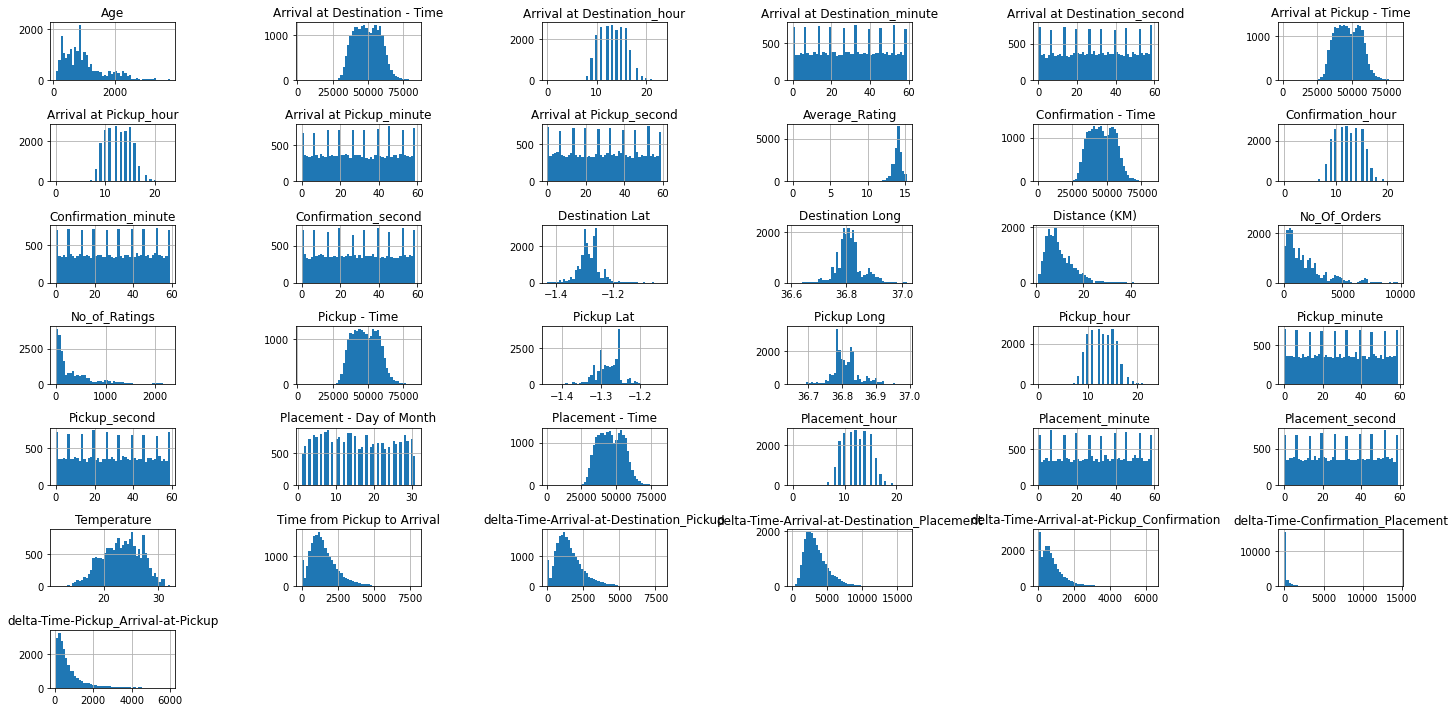

In [45]:
# Distribution review for train data

train_features[[col for col in train_features.select_dtypes(include='number')]].hist(bins=50, figsize=(20,10))

# fix squeezed layout
plt.tight_layout()
plt.show()

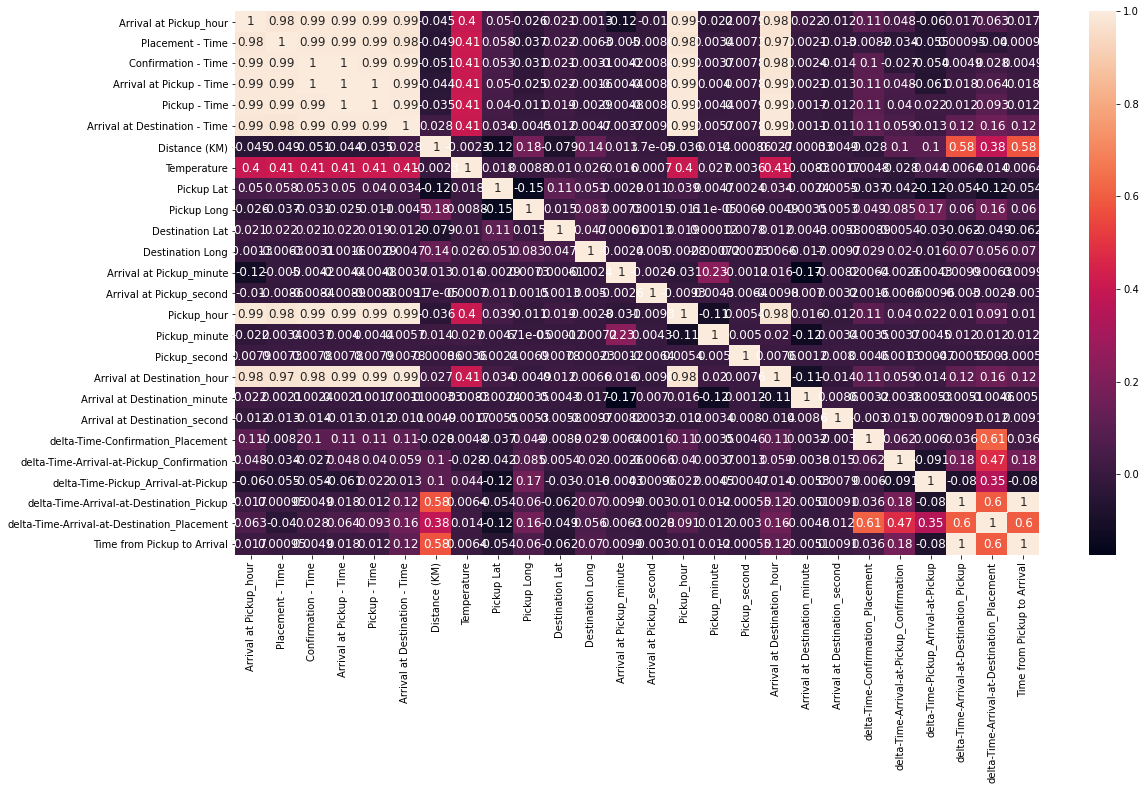

In [64]:
# plot a heatmap conveying the correlation of the variables
cormat = train_features[['Arrival at Pickup_hour',
                         'Placement - Time',
 'Confirmation - Time',
 'Arrival at Pickup - Time',
 'Pickup - Time',
 'Arrival at Destination - Time',
 'Distance (KM)',
 'Temperature',
 'Pickup Lat',
 'Pickup Long',
 'Destination Lat',
 'Destination Long',
 'Arrival at Pickup_minute',
 'Arrival at Pickup_second',
 'Pickup_hour',
 'Pickup_minute',
 'Pickup_second',
 'Arrival at Destination_hour',
 'Arrival at Destination_minute',
 'Arrival at Destination_second',
 'delta-Time-Confirmation_Placement',
 'delta-Time-Arrival-at-Pickup_Confirmation',
 'delta-Time-Pickup_Arrival-at-Pickup',
 'delta-Time-Arrival-at-Destination_Pickup',
 'delta-Time-Arrival-at-Destination_Placement',
 'Time from Pickup to Arrival',]].corr(method='pearson')
# set figsize
fig, ax = plt.subplots(figsize=(18,10))

# plot heatmap with cormat
sns.heatmap(data=cormat, annot=True, annot_kws={'size':12})
plt.show()

**Check linear assumption on the numeric the features**

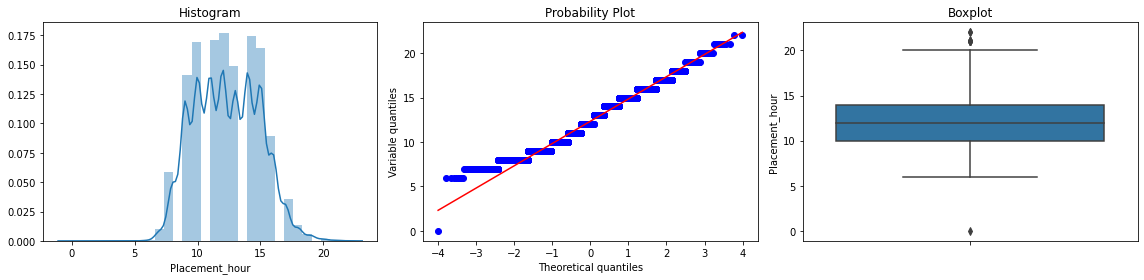

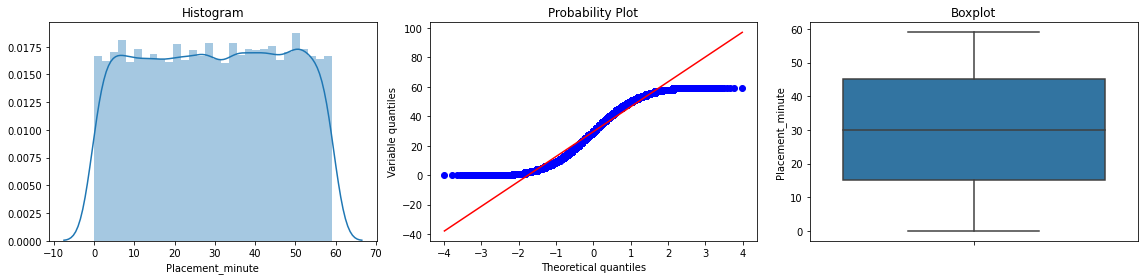

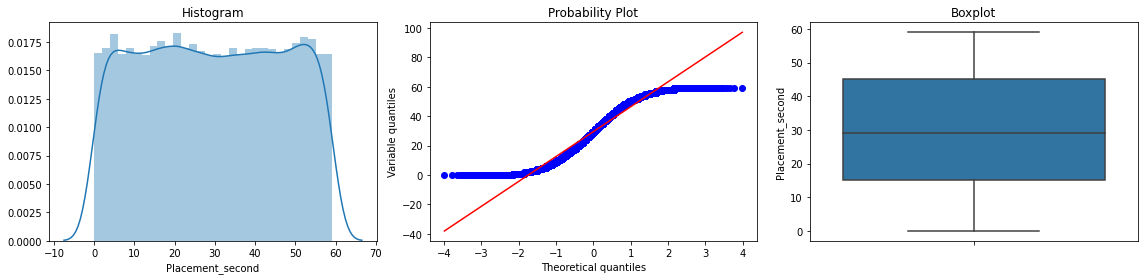

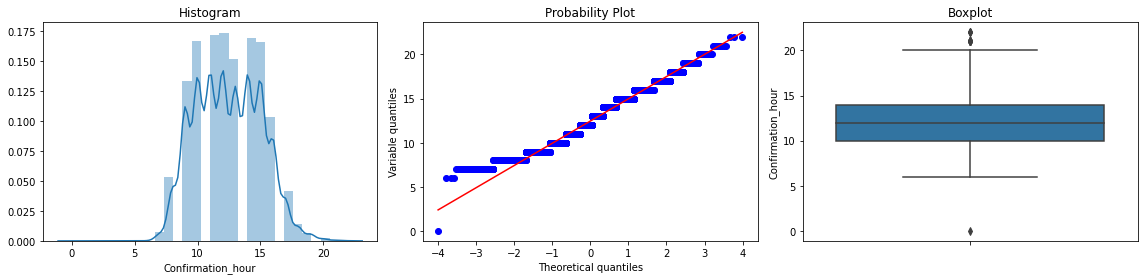

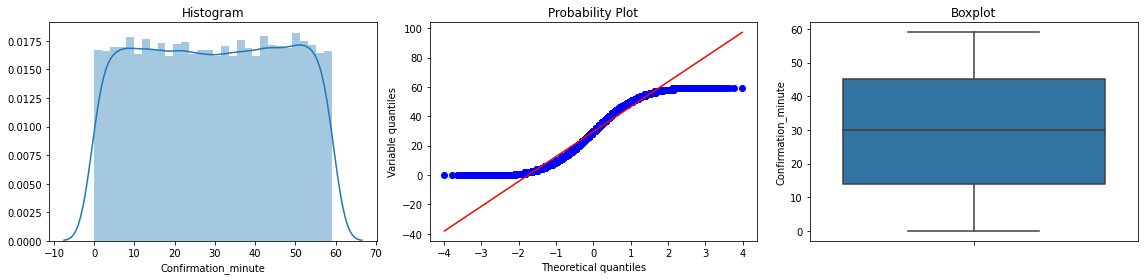

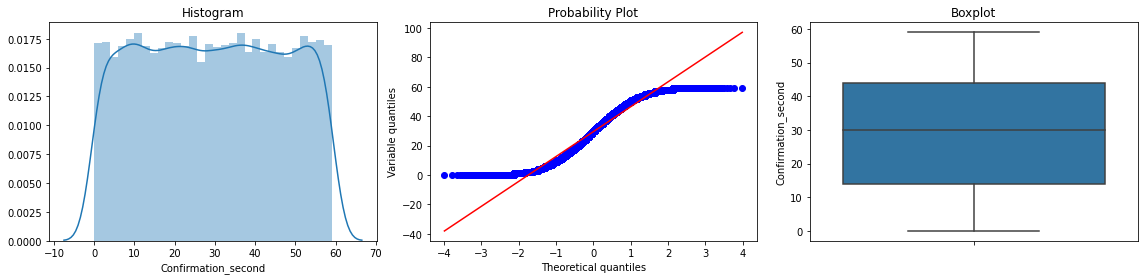

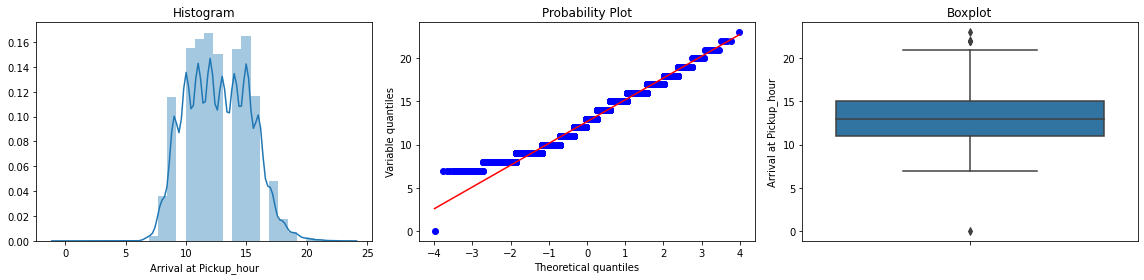

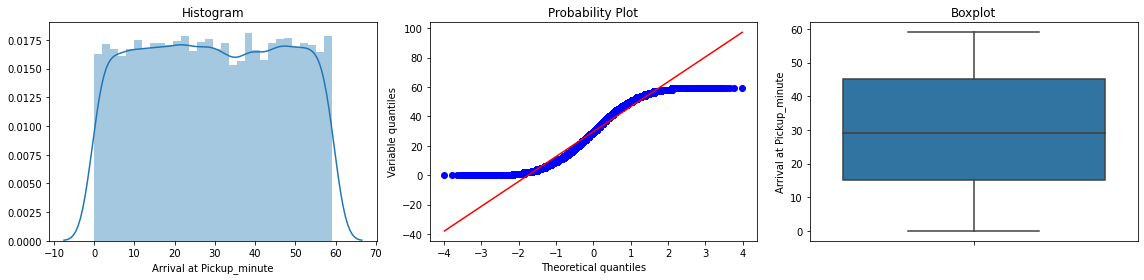

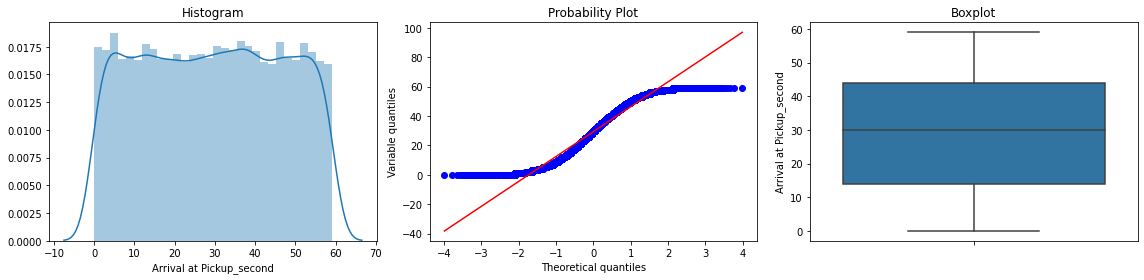

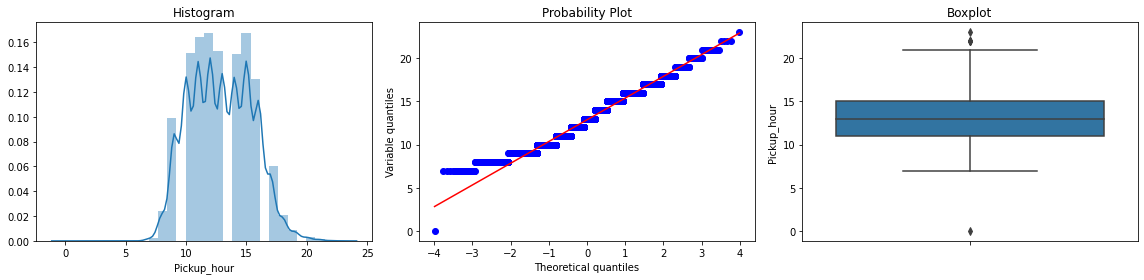

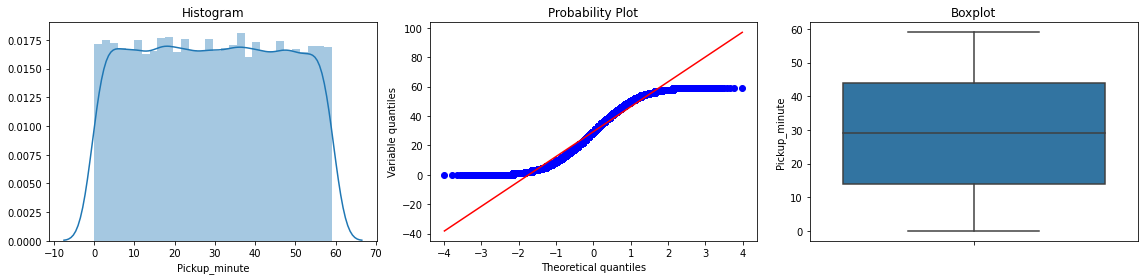

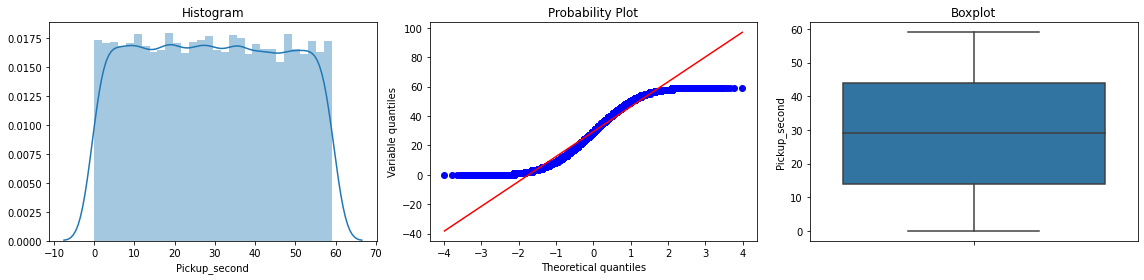

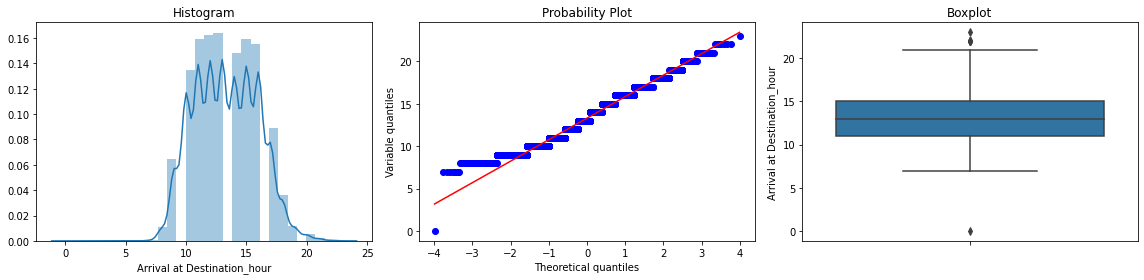

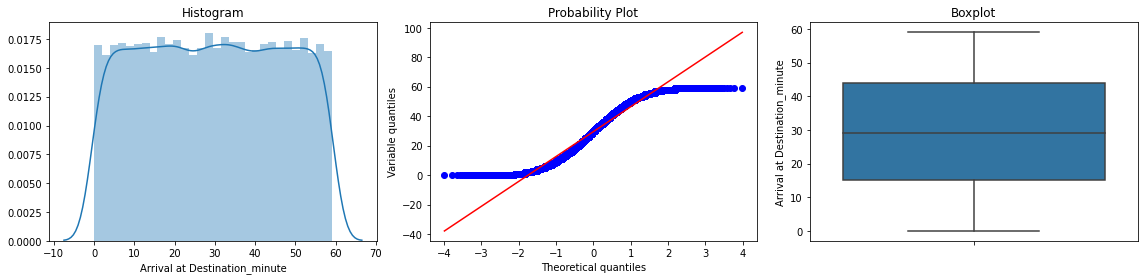

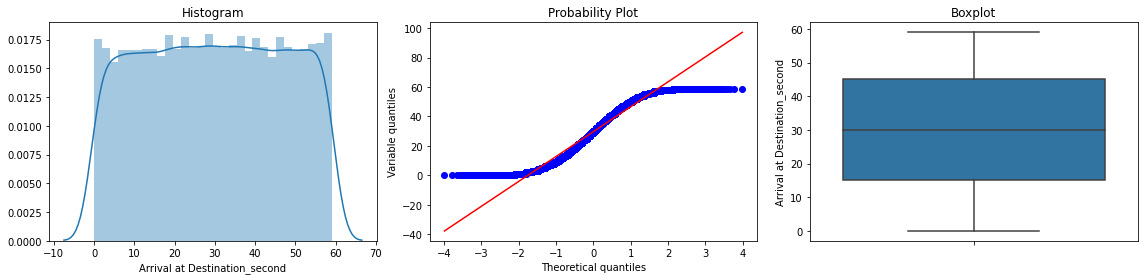

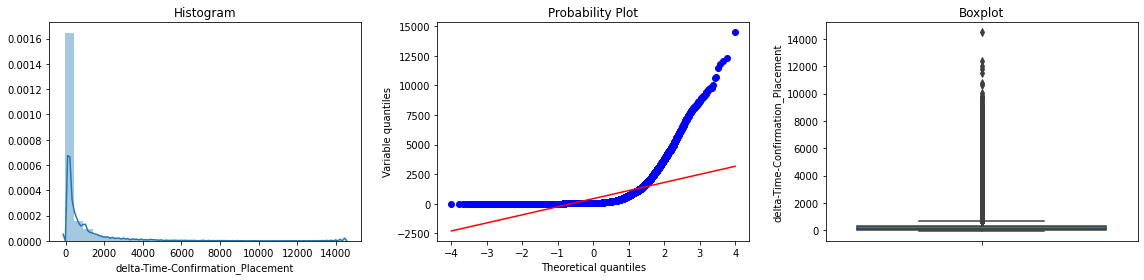

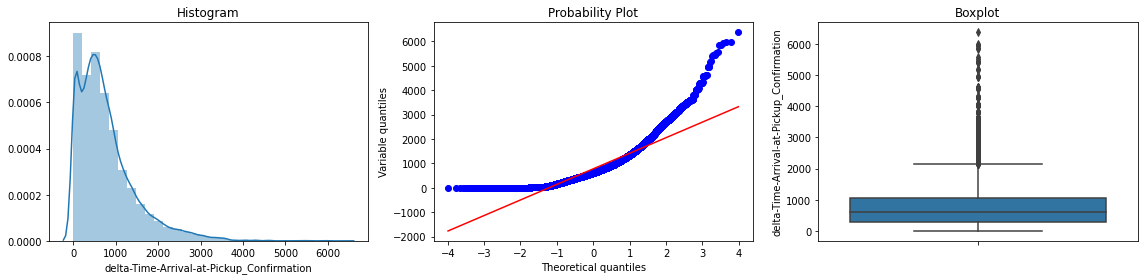

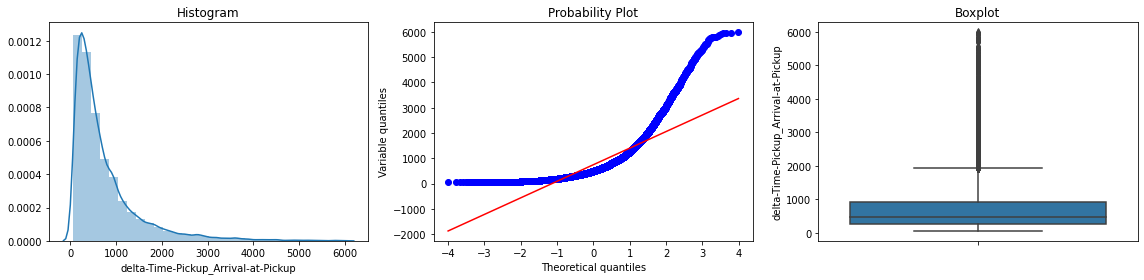

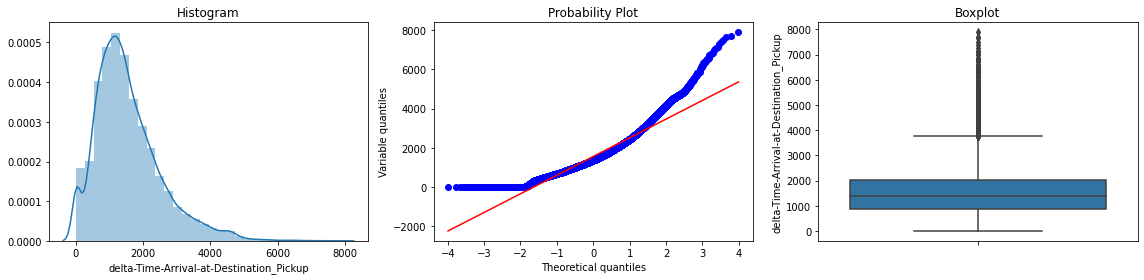

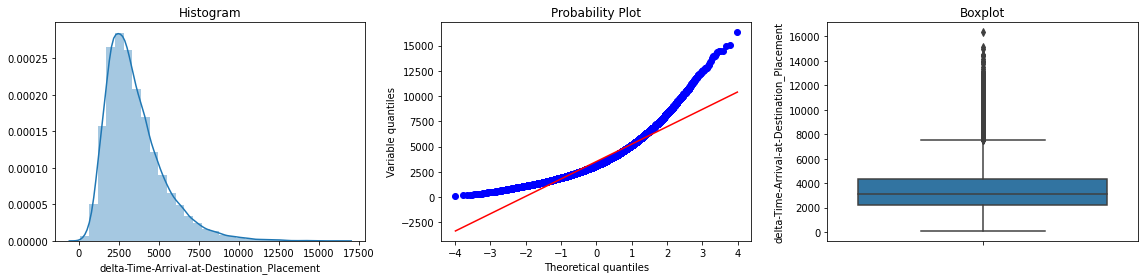

In [53]:
chec_cols =  ['Placement_hour',
 'Placement_minute',
 'Placement_second',
 'Confirmation_hour',
 'Confirmation_minute',
 'Confirmation_second',
 'Arrival at Pickup_hour',
 'Arrival at Pickup_minute',
 'Arrival at Pickup_second',
 'Pickup_hour',
 'Pickup_minute',
 'Pickup_second',
 'Arrival at Destination_hour',
 'Arrival at Destination_minute',
 'Arrival at Destination_second',
 'delta-Time-Confirmation_Placement',
 'delta-Time-Arrival-at-Pickup_Confirmation',
 'delta-Time-Pickup_Arrival-at-Pickup',
 'delta-Time-Arrival-at-Destination_Pickup',
 'delta-Time-Arrival-at-Destination_Placement']

for variable in chec_cols:
  diagnostic_plots(train_features, variable)

# **Data Preparation**
---

**NB:** The following features are not in test data
<br>

```
  ['Arrival at Destination - Time',
  'Arrival at Destination_hour',
  'Arrival at Destination_minute',
  'Arrival at Destination_second',
  'delta-Time-Arrival-at-Destination_Pickup',
  'delta-Time-Arrival-at-Destination_Placement']
```

In [55]:
# Train Missing Data
get_missing_values(train_features, threshold =0)

,% of Missing values
Temperature,0.205953


### Get features in test data

In [110]:
# separate numeric and categorical columns using the train
numeric_cols     = [col for col in train_features.select_dtypes(include='number') if col in test_features]
categorical_cols = [col for col in train_features.select_dtypes(exclude='number') if col in test_features]

# remove the target
print('Numeric features:\n',numeric_cols)
print('\nCategoric features:\n',categorical_cols)

Numeric features:
 ['Placement - Day of Month', 'Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 'Pickup - Time', 'Distance (KM)', 'Temperature', 'Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long', 'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings', 'Placement_hour', 'Placement_minute', 'Placement_second', 'Confirmation_hour', 'Confirmation_minute', 'Confirmation_second', 'Arrival at Pickup_hour', 'Arrival at Pickup_minute', 'Arrival at Pickup_second', 'Pickup_hour', 'Pickup_minute', 'Pickup_second', 'delta-Time-Confirmation_Placement', 'delta-Time-Arrival-at-Pickup_Confirmation', 'delta-Time-Pickup_Arrival-at-Pickup']

Categoric features:
 ['Platform Type', 'Personal or Business', 'Placement - Weekday (Mo = 1)']


## **Train Test Split**

In [112]:
# separate predictors from the target
X = train_features[numeric_cols + categorical_cols]
y = train_features['Time from Pickup to Arrival']

# split the data into subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

# view X_train, X_valid dimensions
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape


((16959, 33), (4240, 33), (16959,), (4240,))

## **PipeLine**

1. **Missing Value Inputation**
2. **Encoding using OneHotEncoder**
3. **Scaled data incase of distance based models**


In [0]:
# import more models here
from xgboost import XGBRegressor
#
#
#


In [0]:
# Numeric 
numeric_pipe = Pipeline(steps=[  ('numeric_impute', SimpleImputer(strategy='mean')),
                               ('scale', StandardScaler())
                                    ])


# Categorical 
categorical_pipe = Pipeline(steps=[  ('categoric_impute', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', OneHotEncoder()),
                                      ])

# full preprocessing 
preprocessor = ColumnTransformer(transformers=[
                                               ('numeric_preprocess', numeric_pipe, numeric_cols),
                                               ('categorical_preprocess',categorical_pipe, categorical_cols),

                                              ], remainder='passthrough')




In [0]:
# Random Forest Regressor model 
# change your model here!
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# pipeline
pipe = Pipeline(steps=[ 
                       ('preprocessor_transformer', preprocessor),
                       (f"{model.__class__.__name__}",model)
                       ])

# **Modeling**

**Evaluation**

In [0]:
def evaluate(model, X, y ):
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import RepeatedKFold

    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    score = np.mean(scores)

    return np.sqrt(abs(score))

In [136]:
# Evaluation score via cross validation
evaluate(pipe, X_train,y_train )

772.9856978986609

In [0]:
# fit and predict
pipe.fit(X_train, y_train)


In [120]:
y_pred = pipe.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
np.sqrt(mse)

762.6909231520111

# **Hyperparameter Tuning**
---
```
'max_depth': ?
'max_features': ?,
'min_samples_leaf': ?,
'min_samples_split': ?,
'n_estimators': ?

---


```
**Sources**<br>
[Tuning parameters](https://medium.com/@kocur4d/hyper-parameter-tuning-with-pipelines-5310aff069d6)

In [0]:
##
cv=3
n_iter=10
random_state=42

def tune_parameters(model,param_grid, X, y):
      model_grid = RandomizedSearchCV(estimator=model, #use pipeline here
                                      param_distributions=param_grid,
                                      scoring='neg_mean_squared_error',
                                      n_iter=n_iter, 
                                      cv=cv,
                                      random_state=random_state,
                                      n_jobs=-1)
      
      return model_grid.fit(X, y)

In [0]:
########################################################################################
#------------------------------------Random Forest Regressor---------------------------
########################################################################################
rf_param_grid = {'n_estimators': np.arange(10,300,10),
                'criterion': ['mse', 'mae'],
                'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
                'min_samples_split': [2, 5, 7, 9, 10],
                'min_samples_leaf' : [1, 2, 4, 7, 9],
                'max_features' : ['auto', 'sqrt', 'log2'],
                'bootstrap': [True, False]
                }

rf_model = RandomForestRegressor(random_state=random_state)


#--------------Search for Parameters-------------------------
# change X and Y to X_train, y_train

model_grid = tune_parameters(pipe,rf_param_grid, X_train, y_train)

best_model = model_grid.best_estimator_
best_model_param = model_grid.best_params_ 

print('best_estimator_:', model_grid.best_estimator_)
print('--0--0'*50)
print('best_params_:', best_model_param)


In [0]:
########################################################################################
#-----------------------------------------XGBOOST---------------------------------------
########################################################################################
param_grid = {'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
              'n_estimators':[10, 30, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 
              'subsample': [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1],
              'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)], 
              'colsample_bytree': [0.5, 0.7, 0.9, 1],
              'min_child_weight': [1, 2, 3, 4]
              }


xgb_model = XGBRegressor(random_state=random_state, n_jobs=-1, verbosity=0)





In [0]:
model_grid.fit(X_train,y_train)

# Final

In [0]:
# final model here

In [144]:
# fit with all the training data
pipe.fit(X,y)

Pipeline(memory=None,
         steps=[('preprocessor_transformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric_preprocess',
                                                  Pipeline(memory=None,
                                                           steps=[('numeric_impute',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                      

In [0]:
y_pred_final = pipe.predict(X)

In [146]:
mse = mean_squared_error(y, y_pred_final)
np.sqrt(mse)

286.4565454525603

# Test data

In [0]:
test_df = test_features
test_df.reset_index(inplace=True)

In [157]:
test_df.head()

,Order No,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Placement_hour,Placement_minute,Placement_second,Confirmation_hour,Confirmation_minute,Confirmation_second,Arrival at Pickup_hour,Arrival at Pickup_minute,Arrival at Pickup_second,Pickup_hour,Pickup_minute,Pickup_second,delta-Time-Confirmation_Placement,delta-Time-Arrival-at-Pickup_Confirmation,delta-Time-Pickup_Arrival-at-Pickup
0,Order_No_19248,Type 3,Business,27,Wednesday,60250.0,60269.0,60784.0,61607.0,8,NaN,-1.333275,36.870815,-1.305249,36.822390,439,1511,13.3,171,16,44,10,16,44,29,16,53,4,17,6,47,19.0,515.0,823.0
1,Order_No_12736,Type 3,Business,17,Friday,46655.0,46757.0,48027.0,48337.0,5,NaN,-1.272639,36.794723,-1.277007,36.823907,488,273,14.4,45,12,57,35,12,59,17,13,20,27,13,25,37,102.0,1270.0,310.0
2,Order_No_768,Type 3,Business,27,Thursday,40094.0,41105.0,41600.0,43074.0,5,22.8,-1.290894,36.822971,-1.276574,36.851365,833,460,13.1,67,11,8,14,11,25,5,11,33,20,11,57,54,1011.0,495.0,1474.0
3,Order_No_15332,Type 3,Business,17,Monday,49895.0,50007.0,50561.0,51412.0,5,24.5,-1.290503,36.809646,-1.303382,36.790658,487,560,13.7,44,13,51,35,13,53,27,14,2,41,14,16,52,112.0,554.0,851.0
4,Order_No_21373,Type 3,Business,11,Tuesday,41428.0,41685.0,42439.0,42964.0,6,24.4,-1.281081,36.814423,-1.266467,36.792161,4761,1120,14.1,1010,11,30,28,11,34,45,11,47,19,11,56,4,257.0,754.0,525.0


In [158]:
predictions = pipe.predict(test_df.drop('Order No', axis=1))

/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [0]:
test_df['Time from Pickup to Arrival']=predictions

In [162]:
test_df[['Order No', 'Time from Pickup to Arrival']]

,Order No,Time from Pickup to Arrival
0,Order_No_19248,1473.37
1,Order_No_12736,1443.52
2,Order_No_768,1258.24
3,Order_No_15332,1262.98
4,Order_No_21373,1091.42
...,...,...
7063,Order_No_3612,1293.20
7064,Order_No_7657,3150.55
7065,Order_No_1969,1704.55
7066,Order_No_10591,2857.14


In [0]:
p = sample_submistion[['Order_No']]

In [0]:
    saved_at = datetime.now().strftime("%m-%d-%Y-at-%H-%M-%S")
    name ='{}_submission.csv'.format(saved_at)

In [0]:
p['Time from Pickup to Arrival'] = predictions.round()

In [172]:
p.head()

,Order_No,Time from Pickup to Arrival
0,Order_No_19248,1473.0
1,Order_No_12736,1444.0
2,Order_No_768,1258.0
3,Order_No_15332,1263.0
4,Order_No_21373,1091.0


In [0]:
p.to_csv(name, index=False)

# Submition
---



In [103]:
sample_submistion = pd.read_csv(url_submission)
sample_submistion.head()

,Order_No,Time from Pickup to Arrival
0,Order_No_19248,567.0
1,Order_No_12736,4903.0
2,Order_No_768,5649.0
3,Order_No_15332,NaN
4,Order_No_21373,NaN


In [0]:
def Submission(X_test_df, model, submistion_df = sample_submistion):

    predictions = model.predict(X_test)
    submistion['Time from Pickup to Arrival'] = predictions.reshape((predictions.shape[0]))

    # create timestamp
    saved_at = datetime.now().strftime("%m-%d-%Y-at-%H-%M-%S")
    name ='{}_submission.csv'.format(saved_at)

    # save 
    submission.to_csv(name, index=False)

    return name

# **Save Model**
---

In [0]:
def save_model(model):
    import pickle
    from datetime import datetime

    saved_at = datetime.now().strftime("%m-%d-%Y-at-%H-%M-%S")
    model_save_path = "{}_{}_model.plk".format(saved_at,model.__class__.__name__)

    with open(model_save_path, 'wb') as file:
        pickle.dump(model, file)

    return model_save_path

In [97]:
save_model(pipe)

'05-29-2020-at-09-46-24_Pipeline_model.plk'